In [1]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display

<function d2l.torch.use_svg_display()>

In [2]:
trans=transforms.ToTensor()
mnist_train=torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
mnist_test=torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [4]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [5]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [31]:
def get_fashion_mnist_labels(labels):
    text_labels=['t-shirt','trouser','pulllover','dress','coat','sandal','shirt','sneaker','bag','ankle boot']
    return [text_labels[int(i)] for i in labels]

In [36]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols*scale, num_rows*scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

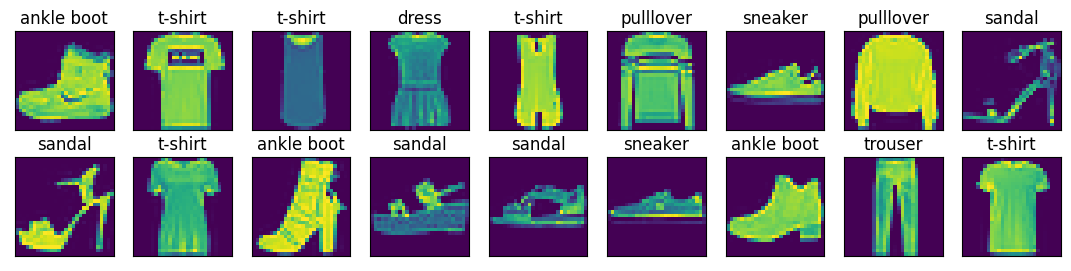

In [37]:
X, y= next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [38]:
batch_size=256

def get_dataloader_workers():
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())

In [39]:
timer=d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f}sec'

'3.49sec'

In [49]:
def load_data_fashion_mnist(batch_size, resize=None):
    trans=[transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans=transforms.Compose(trans)
    mnist_train=torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
    mnis_test=torchvision.datasets.FashionMNIST(root="../data",train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()),
           data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=get_dataloader_workers()))

In [50]:
train_iter, test_iter=load_data_fashion_mnist(32,resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


In [52]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size=256
train_iter, test_iter=d2l.load_data_fashion_mnist(batch_size)

In [53]:
num_inputs= 784
num_outputs= 10

W=torch.normal(0,0.01,size=(num_inputs, num_outputs),requires_grad=True)
b=torch.zeros(num_outputs, requires_grad=True)

In [54]:
X=torch.tensor([[1.0, 2.0, 3.0],[4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1,keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [55]:
def softmax(X):
    X_exp=torch.exp(X)
    partition=X_exp.sum(1, keepdim=True)
    return X_exp/partition

In [57]:
X=torch.normal(0,1,(2,5))
X_prob=softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.2043, 0.2193, 0.1283, 0.1205, 0.3277],
         [0.0500, 0.1513, 0.0386, 0.6375, 0.1226]]),
 tensor([1., 1.]))

In [79]:
def net(X):
    return softmax(torch.matmul(X.reshape(-1, W.shape[0]),W)+b)

In [59]:
y= torch.tensor([0,2])
y_hat=torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]])
y_hat[[0,1],y]

tensor([0.1000, 0.5000])

In [60]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)),y])
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [61]:
def accuracy(y_hat, y):
    if len(y_hat.shape)>1 and y_hat.shape[1]>1:
        y_hat=y_hat.argmax(axis=1)
    cmp=y_hat.type(y.dtype)==y
    return float(cmp.type(y.dtype).sum())

In [62]:
accuracy(y_hat, y)/len(y)

0.5

In [80]:
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric=Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]

In [81]:
class Accumulator:
    def __init__(self, n):
        self.data=[0,0]*n
        
    def add(self, *args):
        self.data=[a+float(b) for a, b in zip(self.data, args)]
        
    def reset(self):
        self.data=[0,0]*len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

In [82]:
evaluate_accuracy(net, test_iter)

0.0231

In [127]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric=Accumulator(3)
    for X, y in train_iter:
        y_hat=net(X)
        l=loss(y_hat,y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.mean().backward()
        else:
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()),accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [128]:
class Animator:
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None, ylim=None, xscale='linear', yscale='linear',
                fmts=('-','m--','g-.','r:'), nrows=1, ncols=1, figsize=(3.5, 2.5)):
        if legend is None:
            legend=[]
        d2l.use_svg_display()
        self.fig, self.axes=d2l.plt.subplots(nrows, ncols, figsize= figsize)
        if nrows*ncols==1:
            self.axes=[self.axes, ]
        self.config_axes=lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts= None, None, fmts
            
    def add(self, x, y):
        if not hasattr(y, '__len__'):
            y=[y]
        n=len(y)
        if not hasattr(x, '__len__'):
            x=[x]*n
        if not self.X:
            self.X=[[] for _ in range(n)]
        if not self.Y:
            self.Y=[[] for _ in range(n)]
        for i, (a,b) in enumerate(zip(x,y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

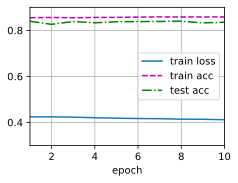

In [129]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator= Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics=train_epoch_ch3(net, train_iter, loss, updater)
        test_acc= evaluate_accuracy(net, test_iter)
        animator.add(epoch+1, train_metrics+(test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss<0.5, train_loss
    assert train_acc<=1 and train_acc>0.7, train_acc
    assert test_acc<=1 and test_acc>0.7, test_acc
    
lr=0.1
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

num_epochs=10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

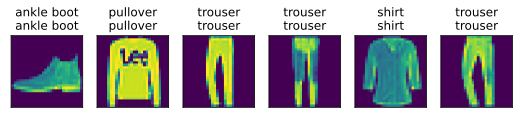

In [133]:
def predict_ch3(net, test_iter, n=6):
    for X, y in test_iter:
        break
    trues=d2l.get_fashion_mnist_labels(y)
    preds=d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles=[true+'\n'+pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)),1, n, titles=titles[0:n])
    
predict_ch3(net, test_iter)

In [134]:
from torch import nn

batch_size=256
trian_iter, test_iter=d2l.load_data_fashion_mnist(batch_size)

In [135]:
net= nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
net.apply(init_weights);

In [136]:
loss=nn.CrossEntropyLoss(reduction='none')

In [137]:
trainer=torch.optim.SGD(net.parameters(), lr=0.1)

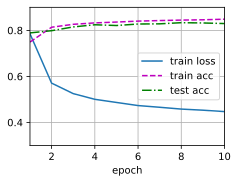

In [140]:
num_epoches=10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)